In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import PIL
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import librosa

from PIL import Image

In [2]:
ACTIONS = [['LEFT'], ['RIGHT'], ['LEFT', 'DOWN'], ['RIGHT', 'DOWN'], ['DOWN'],
           ['DOWN', 'B'], ['B']]

In [3]:
from scipy.io.wavfile import read
import numpy as np
import librosa
import librosa.display
sr, a = read("/tmp/temp.wav")
print(a[:20])
print(a.dtype)
print(a.shape)
a = a / 2.0**15#np.float32(a)
print(a[:20])
print(a.dtype)
print(a.shape)

aud = Audio("/tmp/temp.wav")
display(aud)

[   0    0    0   -1    6    0   28   17  252  928 1528 2058 2567 2983
 3295 3465 3499 3415 3212 2945]
int16
(220500,)
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.05175781e-05
  1.83105469e-04  0.00000000e+00  8.54492188e-04  5.18798828e-04
  7.69042969e-03  2.83203125e-02  4.66308594e-02  6.28051758e-02
  7.83386230e-02  9.10339355e-02  1.00555420e-01  1.05743408e-01
  1.06781006e-01  1.04217529e-01  9.80224609e-02  8.98742676e-02]
float64
(220500,)


(512, 862)


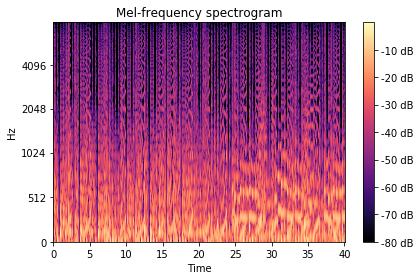

[[ -8.635038 -17.407003 -22.007545 ...  -8.104303 -10.558573 -16.853924]
 [ -8.959899 -17.765047 -21.973196 ...  -8.274503 -10.739824 -17.26884 ]
 [ -9.502951 -18.359207 -21.852966 ...  -8.555107 -11.035188 -17.917023]
 ...
 [-72.54608  -80.       -80.       ... -68.15539  -74.88381  -71.17788 ]
 [-80.       -78.8862   -80.       ... -68.56804  -70.09681  -69.2034  ]
 [-80.       -72.79389  -80.       ... -72.36867  -68.00088  -72.36361 ]]


In [21]:
n_fft = 512
mels = librosa.feature.melspectrogram(y=a, sr=sr, n_mels=n_fft, win_length=n_fft//2, hop_length=n_fft//2)
mels_db = librosa.power_to_db(mels, ref=np.max)
print(mels_db.shape)
librosa.display.specshow(mels_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()
print(mels_db)

[ 0.          0.          0.         ... -0.13565063 -0.11016846
 -0.08361816]
(128, 3446) float32 0.0 -80.0
[[-14.1995125  -8.573536  -26.449741  ... -17.576746  -28.882792
   -8.692638 ]
 [-15.413884   -9.074018  -22.947357  ... -17.089096  -25.489359
   -9.387142 ]
 [-17.560213   -9.901825  -19.802607  ... -16.871986  -23.990873
  -10.557098 ]
 ...
 [-75.16828   -68.561485  -68.35236   ... -74.7682    -69.20889
  -61.10016  ]
 [-75.42495   -71.28953   -71.162445  ... -76.37798   -75.82579
  -62.529602 ]
 [-77.84509   -71.86232   -73.67635   ... -74.65381   -71.60803
  -63.297623 ]]


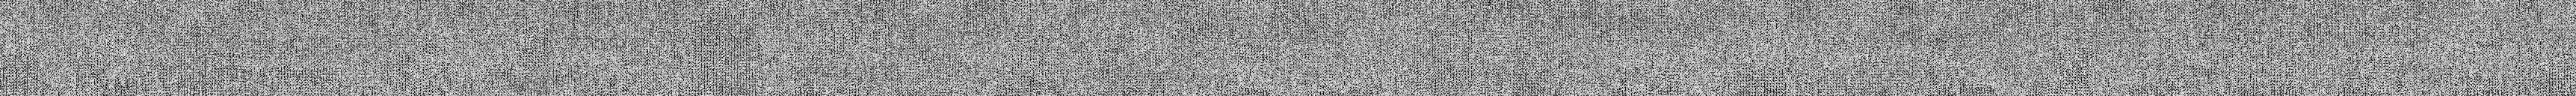

In [31]:
print(a)
mels = librosa.feature.melspectrogram(y=a, sr=sr, n_mels=128, win_length=128, hop_length=64)
mels_db = librosa.power_to_db(mels, ref=np.max)
print(mels_db.shape, mels_db.dtype, mels_db.max(), mels_db.min())
print(mels_db)

aud_im = Image.fromarray(mels_db, 'P')
display(aud_im)

[ 0.          0.          0.         ... -0.13565063 -0.11016846
 -0.08361816]
(512, 862) uint8 255 0
[[229 201 186 ... 231 223 203]
 [228 200 186 ... 230 222 201]
 [226 198 187 ... 229 221 199]
 ...
 [ 25   1   1 ...  39  18  30]
 [  1   5   1 ...  38  33  36]
 [  1  24   1 ...  26  40  26]]


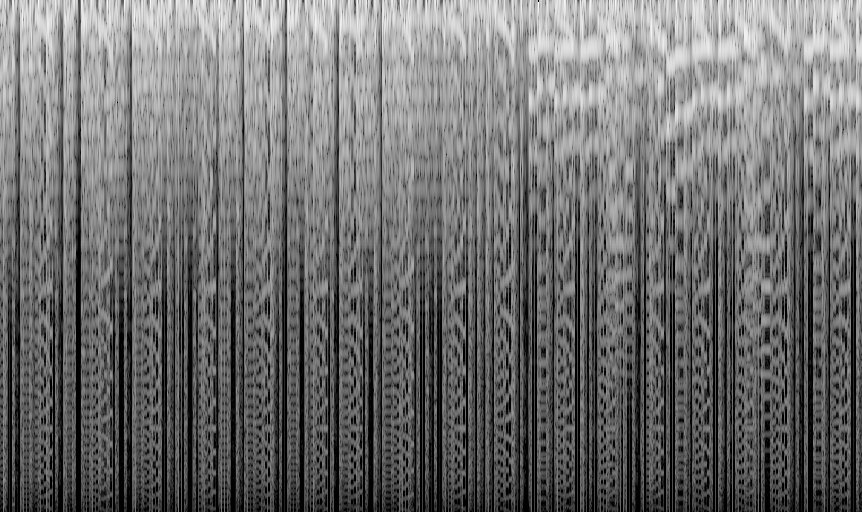

In [33]:
print(a)
n_fft = 512
mels = librosa.feature.melspectrogram(y=a, sr=sr, n_mels=n_fft, win_length=n_fft//2, hop_length=n_fft//2)
mels_db = librosa.power_to_db(mels, ref=np.max)
mels_db = np.uint8(mels_db/80*255)
print(mels_db.shape, mels_db.dtype, mels_db.max(), mels_db.min())
print(mels_db)

aud_im = Image.fromarray(mels_db, 'L')
display(aud_im)

In [ ]:
from visualize.visualize import gen_eval_vid_frame
from a2c_ppo_acktr.envs import make_vec_envs


In [ ]:
seed = 10
device = "cuda:0"
env_state = "GreenHillZone.Act1"
env = make_vec_envs(
    [env_state],
    seed + 1000,
    1,
    None,
    device=device,
    allow_early_resets=False,
    mode='eval')

In [ ]:
from a2c_ppo_acktr.model import Policy

obs_space = env.observation_space
obs_module = {'video': 'video-large', 'audio': 'audio-small'}
assert set(obs_space.spaces.keys()) == set(obs_module.keys()), "Observation spaces and modules must have same keys."
actor_critic = Policy(
    obs_space,
    obs_module,
    env.action_space,
    base_kwargs={'recurrent': False})
env_step = 0
episode_num = 0
actor_critic.to(device)
actor_critic.train()

In [ ]:
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size).to(device)
masks = torch.zeros(1, 1).to(device)

obs = env.reset()
i = 0
info = None
while True:
    if i >= 1:
        break
    with torch.no_grad():
        value, action, _, recurrent_hidden_states, logits = actor_critic.act(
            obs, recurrent_hidden_states, masks, deterministic=True)

    x = 0 if info is None else info[0]['x']
    max_x = 0 if info is None else info[0]['max_x']
    pct = 0 if info is None else info[0]['max_x']/info[0]['lvl_max_x']*100
    rew = 0 if info is None else info[0]['sum_r']
    t = i
    actn = action.item()
    tgt_layer = {'video': 5}
    f = gen_eval_vid_frame(
        actor_critic, env_state, x, max_x, pct, rew, t, actn, logits, obs, tgt_layer)
    print(f.shape)
    display(Image.fromarray(f, 'L'))
    

    # Obser reward and next obs
    obs, reward, done, info = env.step(action)
    masks.fill_(0.0 if done else 1.0)
    
    if done:
        print(f"max_x {info[0]['max_x']}, stage len {info[0]['screen_x_end']}")
        break
    i += 1

In [ ]:
print(f)